In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
# !pip install -r requirements.txt

# Data: CelebA

## Dataset

In [3]:
from src.modules.celeba_data_module import CelebADataset, CelebA_DataModule
from src.tools.dataset_tools import get_dataset_filename_map, dataset_gdrive_download, get_labels
import config_celeba
import os
import numpy as np

# download celeba dataset
dataset_gdrive_download(config = config_celeba)

# get labels map
labels_map = get_labels(config = config_celeba)

print('Number of class in label map', len(list(labels_map.keys())) )
# print()
# print('Number of samples per person')
# for i, (k, v) in enumerate(list(labels_map.items())):
#     print(len(v))
#     if i >5:
#         break
print('\ntesting dataset')

num_classes=100

dataset = CelebADataset(labels_map, num_classes=list(range(num_classes)))
print('nb samples', len(dataset))
print('nb classes in dataloader', dataset.nb_classes())

Dataset already downloaded
Labels already downloaded
Number of class in label map 10177

testing dataset
nb samples 2234
nb classes in dataloader 100


 Train dataset ----------------------------




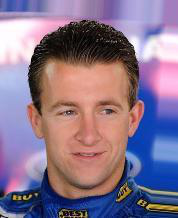

label 0
shape (178, 218)




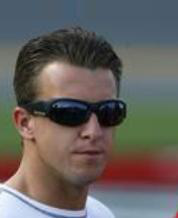

label 0
shape (178, 218)


In [4]:
#image from train dataset
print(" Train dataset ----------------------------")
for i, (image, label) in enumerate(dataset):
    print("\n")
    display(image)
    print("label",label)
    print('shape', image.size)
    if i==1:
        break


## Dataloader with custom sampler

In [5]:
import multiprocessing as mp
from src.modules.celeba_data_module import DATASETS

num_classes_iter = 4
batch_size = 16
dataloader = CelebA_DataModule(name=DATASETS.CELEBA, nb_classes=num_classes, class_split=True, batch_size = batch_size,
                               num_classes_iter=num_classes_iter, splitting_points=(0.10, 0.10),  
                               input_shape = (3, 256, 256), num_workers = mp.cpu_count())

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

train classes 0 90
test classes 90 100
split size 1790 198 246
Number of train batches 112
Number of valid batches 7
Number of test batches 8


max value 1.0
min value 0.0
shape torch.Size([16, 3, 256, 256])
[tensor(5), tensor(5), tensor(5), tensor(5)]
[tensor(62), tensor(62), tensor(62), tensor(62)]
[tensor(29), tensor(29), tensor(29), tensor(29)]
[tensor(69), tensor(69), tensor(69), tensor(69)]


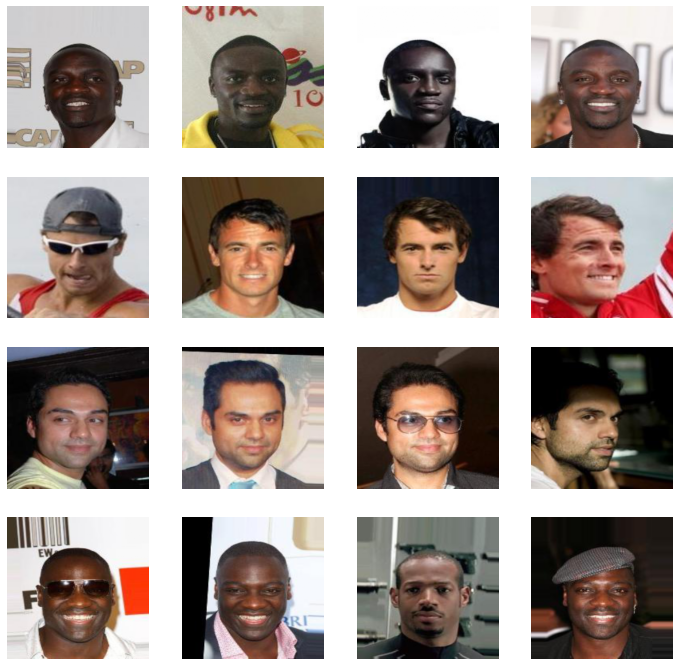

In [6]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

n_row = num_classes_iter
n_cols = int(batch_size/num_classes_iter)

for i, (im, label) in enumerate(train_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=n_row)
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(37), tensor(37), tensor(37), tensor(37)]
[tensor(17), tensor(17), tensor(17), tensor(17)]
[tensor(28), tensor(28), tensor(28), tensor(28)]
[tensor(33), tensor(33), tensor(33), tensor(33)]
[tensor(11), tensor(11), tensor(11), tensor(11)]
[tensor(7), tensor(7), tensor(7), tensor(7)]
[tensor(84), tensor(84), tensor(84), tensor(84)]
[tensor(32), tensor(32), tensor(32), tensor(32)]


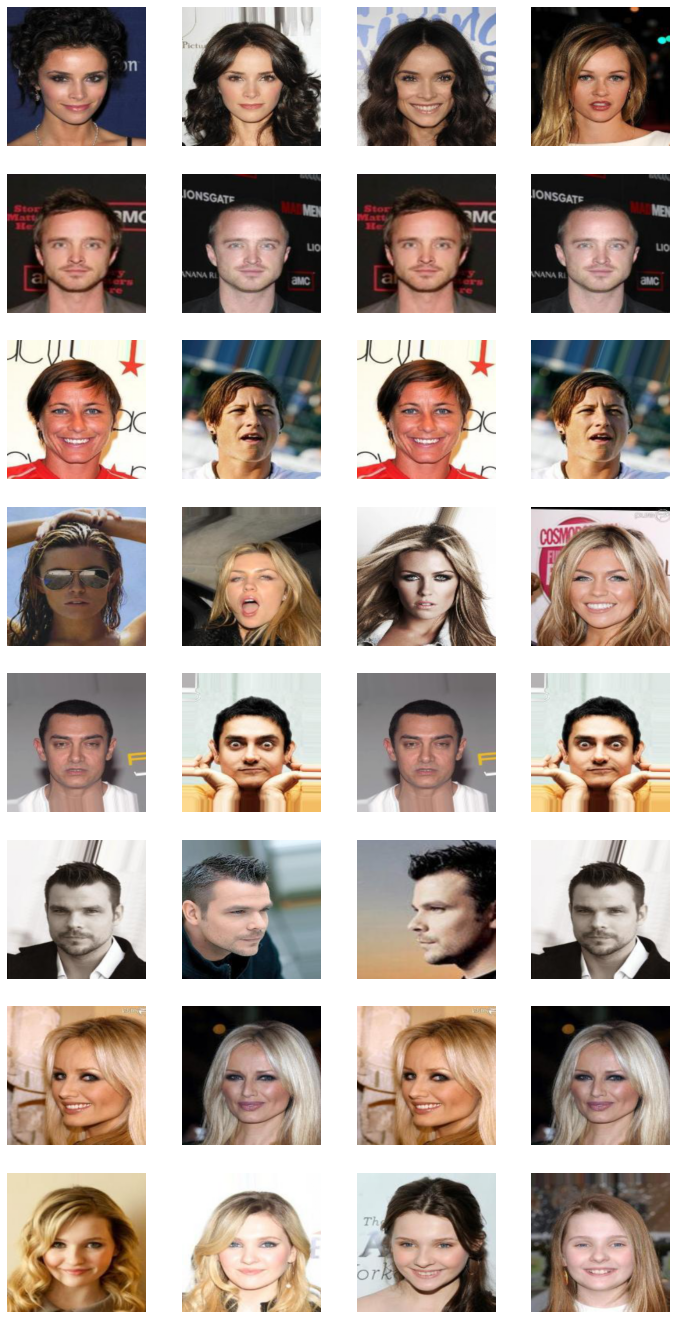

In [7]:
for i, (im, label) in enumerate(val_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(94), tensor(94), tensor(94), tensor(94)]
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(97), tensor(97), tensor(97), tensor(97)]
[tensor(99), tensor(99), tensor(99), tensor(99)]
[tensor(98), tensor(98), tensor(98), tensor(98)]
[tensor(95), tensor(95), tensor(95), tensor(95)]
[tensor(92), tensor(92), tensor(92), tensor(92)]


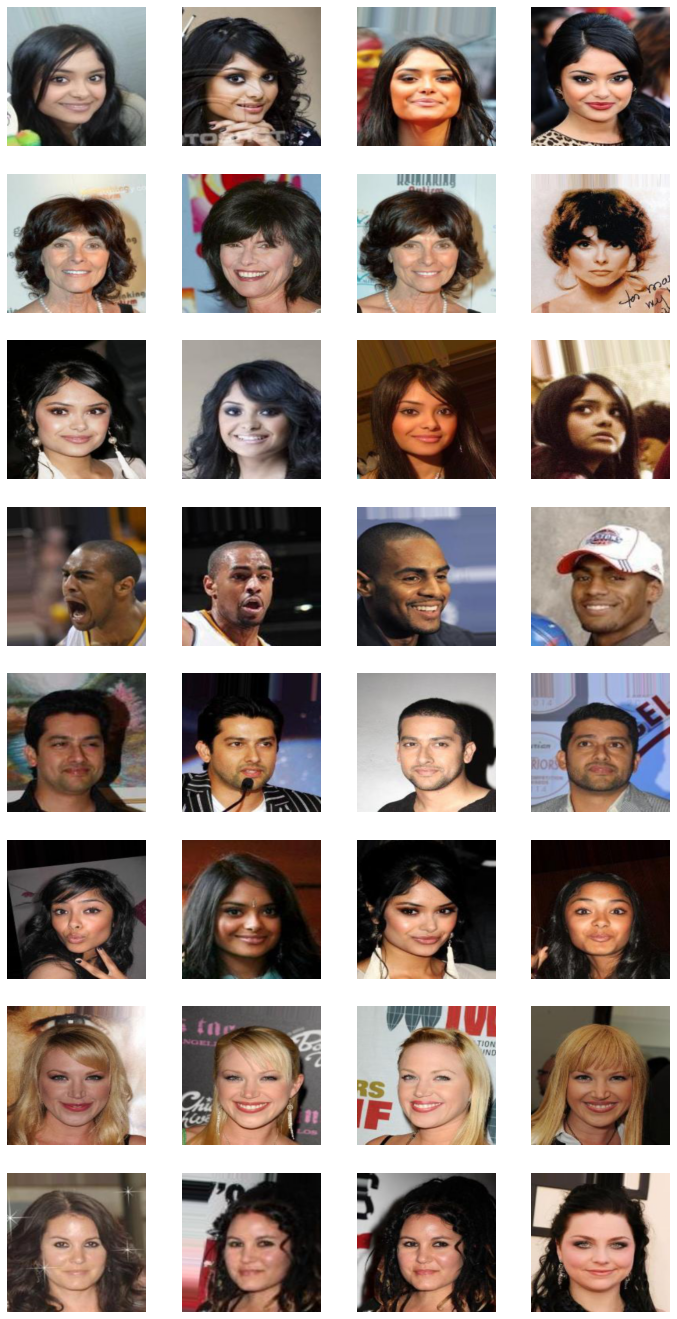

In [8]:
for i, (im, label) in enumerate(test_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=int(n_row*2))
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

# Hyperparameter Tunning

In [9]:
do_tune = False
if do_tune:
    import optuna
    from src.hyper_tune import tune

    study = optuna.create_study( direction="maximize" )
    study.optimize( tune.objective, n_trials=20)

    print( "Number of finished trials: {}".format( len(study.trials) ) )

    print( "Best trial:" )
    trial = study.best_trial

    print( "  Value: {}".format( trial.value ) )

    print( "  Params: " )
    for key, value in trial.params.items():
      print( "    {}: {}".format( key, value ) )

# Training the model

## Choosing the model

In [10]:
from src.model.CustomModelGroupLoss import Siamese_Group, CNN_MODEL_GROUP
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary

# cnn_model = CNN_MODEL_GROUP.MyCNN
cnn_model = CNN_MODEL_GROUP.BN_INCEPTION

if cnn_model == CNN_MODEL_GROUP.MyCNN:
    model_hparams = {
        "lr": 0.001,
        "weight_decay":1e-5,
        "filter_channels": 4,
        "filter_size": 3,
        "dropout": 0.00,
        "n_hidden1": 4096,
        "n_hidden2": 2048,
        'temperature': 10,
        'num_labeled_points_class': 2,
    }
    
    scheduler_params = {
        "step_size": 5,
        "gamma": 0.5,
    }
elif cnn_model == CNN_MODEL_GROUP.BN_INCEPTION:
    model_hparams = {
        "lr": 0.0001602403,
        "weight_decay":8.465428e-5,
        'temperature': 12,
        'num_labeled_points_class': 2
    }
    
    scheduler_params = {
        "step_size": 10,
        "gamma": 0.5,
    }

# scheduler_params = None

num_classes = 10177
# num_classes = 1000

model = Siamese_Group(hparams=model_hparams, 
                cnn_model = cnn_model, 
                scheduler_params = scheduler_params,
                nb_classes = num_classes,
                finetune=False, 
                weights_path=None,
                     )

if torch.cuda.is_available():
    model.to('cuda')
print(summary(model,[ (3, model.input_size, model.input_size)]))
model.cpu()

print("Model input size", model.input_size)

Layers to update
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,784
       BatchNorm2d-9          [-1, 192, 56, 56]             384
             ReLU-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,352
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14  

## Defining the Dataloader

In [11]:
print('len dataset', len(dataset))

num_classes_iter = 8
num_elem_class = 6

batch_size = num_classes_iter*num_elem_class


dataloader = CelebA_DataModule(name=DATASETS.CELEBA, 
                               nb_classes=num_classes, 
                               class_split=True, 
                               batch_size=batch_size, 
                               num_classes_iter=num_classes_iter, 
                               splitting_points=(0.20, 0.20), 
                               input_shape = (3, model.input_size, model.input_size),
                               num_workers = mp.cpu_count(),
                               finetune = False)

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

for i, batch in enumerate(train_loader):
    x, y = batch
    print(x.shape)
    break

len dataset 2234
train classes 0 8141
test classes 8141 10177
split size 131269 32817 38513
Number of train batches 2735
Number of valid batches 342
Number of test batches 402
torch.Size([48, 3, 224, 224])


In [12]:
# %tensorboard --logdir data/tb_group_logs/

## Train Custom Model

Please get the pretrained weights from https://drive.google.com/drive/folders/1tOCWXoAjKkIAvIECfQaKnZEIhl1z2ZGh?usp=sharing and place them in data/net/. for training the neural network

In [13]:
exp_name = 'group_loss_inc_tuned'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_R%_@1',
    patience=10,
    strict=False,
    verbose=False,
    mode='max'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_R%_@1',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Group-{epoch:02d}-{val_loss:.2f}',
    save_top_k=10,
    mode='max',
)

lr_monitor = pl.callbacks.LearningRateMonitor()

trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": [
        early_stop_callback,
        checkpoint_callback,
        lr_monitor,
    ],
    "fast_dev_run": False,
    "max_epochs": 100,
    "gpus":1 if torch.cuda.is_available() else None,
    
}

# logname = 'resnet_BCE'
logger = TensorBoardLogger(os.path.join('data','tb_group_logs'), name=exp_name)

do_train = False

trainer = pl.Trainer(**trainer_params, logger = logger)
if do_train:
    trainer.fit(model, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | gtg        | GTG              | 0     
1 | criterion  | NLLLoss          | 0     
2 | criterion2 | CrossEntropyLoss | 0     
3 | model      | BnInception      | 20.7 M


# Save/Load Checkpoint

## Manual Save

In [14]:
import os

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'saved', 'inc_last')  
    checkpoint_path = os.path.join(save_dir, 'inc_nll_last.ckpt')
    trainer.save_checkpoint(checkpoint_path)

## Load Checkpoint
Download checkpoints from https://drive.google.com/drive/folders/1puXPrBrquphElXiCDuZSIbSYdRqprxG0?usp=sharing and use the checkpoints from group loss

In [30]:
load_checkpoint = True

if load_checkpoint:
#     checkpoint_path = checkpoint_callback.best_model_path
    checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=23-val_loss=2.96.ckpt')
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)


Layers to update


## Retrain from checkpoint

In [31]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = pl.Trainer(**trainer_params, resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [17]:
trainer.test(model, dataloader.val_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_ce_loss': tensor(2.3781, device='cuda:0'),
 'avg_loss': tensor(3.4243, device='cuda:0'),
 'avg_nll_loss': tensor(1.0461, device='cuda:0'),
 'avg_recall@1': tensor(0.9513)}
--------------------------------------------------------------------------------



/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'avg_loss': 3.424269676208496,
  'avg_recall@1': 0.951297402381897,
  'avg_nll_loss': 1.0461246967315674,
  'avg_ce_loss': 2.3781449794769287}]

### Note: Computational heavy!!!!

In [18]:
calc_all_recall = False
calc_nmi = True

In [19]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model.to('cuda'), dataloader=dataloader.val_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall.detach())
    if calc_nmi:
        print('nmi', nmi)

## Run test epoch

In [32]:
trainer.test(model, dataloader.test_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_ce_loss': tensor(12.7319, device='cuda:0'),
 'avg_loss': tensor(14.3156, device='cuda:0'),
 'avg_nll_loss': tensor(1.5837, device='cuda:0'),
 'avg_recall@1': tensor(0.9257)}
--------------------------------------------------------------------------------



[{'avg_loss': 14.315629005432129,
  'avg_recall@1': 0.9256581664085388,
  'avg_nll_loss': 1.5837228298187256,
  'avg_ce_loss': 12.731904983520508}]

### Note: Computational heavy!!!!

In [21]:
from src.tools import evaluation_tool

if calc_all_recall:
    recall, nmi = evaluation_tool.evaluate(model, dataloader=dataloader.test_dataloader(), calc_nmi=calc_nmi)
    print('recall', recall)

    if calc_nmi:
        print('nmi', nmi)

# Inference and Visualization

torch.Size([96, 3, 224, 224])


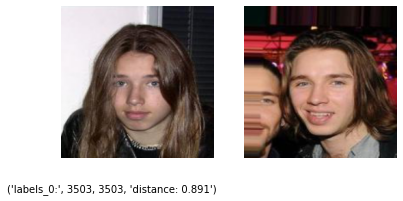

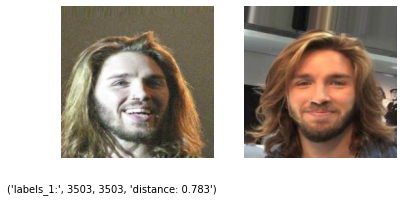

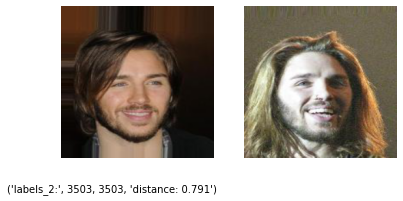

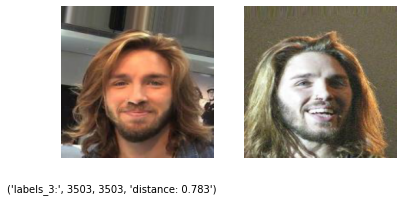

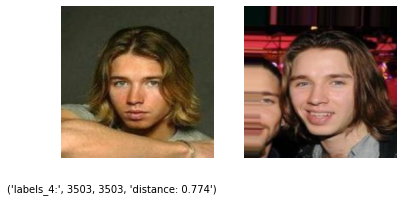

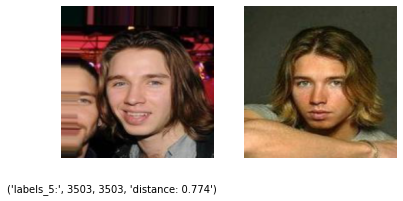

In [52]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn


for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.val_dataloader()):
    print(x.shape)
    for img_idx, closest_idx in enumerate(indices[:, 0]):        
        img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
        caption = f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx])
        visualize_torch(img_matches, n_cols=2, n_rows=1, caption=caption)
        if int(img_idx) == 5:
            break
    break


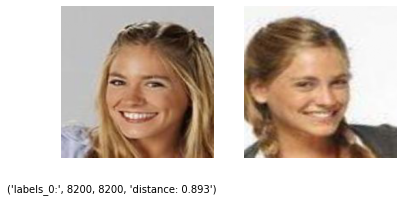

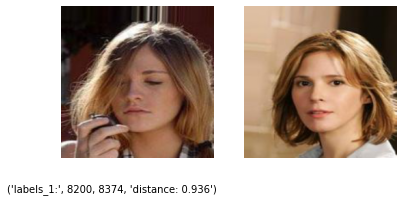

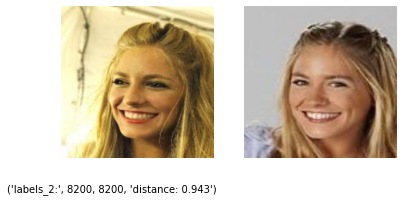

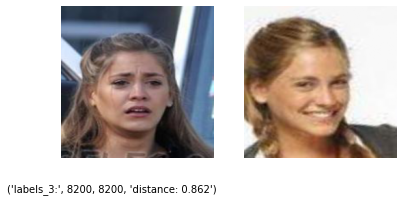

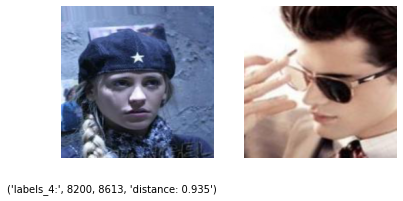

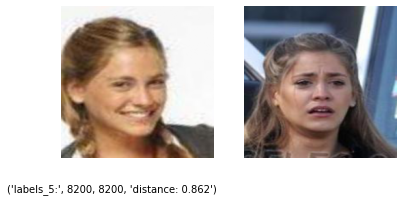

In [54]:
from src.tools.model_tools import get_k_similar_group
from src.tools import evaluation_tool
from src import evaluation
from torch.utils import data
import sklearn


for x, y, indices, distances in get_k_similar_group(model, loader=dataloader.test_dataloader()):
    for img_idx, closest_idx in enumerate(indices[:, 0]):        
        img_matches = torch.stack([ x[int(img_idx)], x[int(closest_idx)] ])
        caption = f'labels_{img_idx}:', y[int(img_idx)].item(), y[int(closest_idx)].item(), 'distance: {:.3f}'.format(distances[img_idx, closest_idx])
        visualize_torch(img_matches, n_cols=2, n_rows=1, caption=caption)
        if int(img_idx) == 5:
            break
    break